In [1]:
import sys
import numpy as np
import nibabel as nib
import scipy.stats as stats
from scipy.linalg import pinv
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import gamma
from scipy.signal import convolve

def spm_hrf(tr, duration=32, oversampling=16):
    dt = tr / oversampling
    time_points = np.arange(0, duration, dt)
    
    # Parameters (SPM-like)
    peak_values = gamma.pdf(time_points, 6)
    undershoot_values = gamma.pdf(time_points, 16)
    
    hrf = peak_values - 0.5 * undershoot_values
    hrf = hrf / np.max(hrf)
    return hrf


def load_ev_files(ev_list_file, n_timepoints, tr):
    with open(ev_list_file, 'r') as f:
        ev_files = [line.strip() for line in f if line.strip()]

    design_matrix = np.zeros((n_timepoints, len(ev_files)))
    hrf = spm_hrf(tr)

    for idx, ev_file in enumerate(ev_files):
        ev_data = np.loadtxt(ev_file)
        if ev_data.ndim == 1:
            ev_data = ev_data[np.newaxis, :]

        stimulus = np.zeros(n_timepoints)
        for start, duration, value in ev_data:
            onset_idx = int(start / tr)
            duration_idx = max(1, int(duration / tr))
            end_idx = min(onset_idx + duration_idx, n_timepoints)
            stimulus[onset_idx:end_idx] = value

        # Convolve with HRF and truncate to original length
        convolved = convolve(stimulus, hrf)[:n_timepoints]
        design_matrix[:, idx] = convolved


    # Visualize Design Matrix
    plt.imshow(design_matrix, aspect='auto', cmap='gray')
    plt.title("Design Matrix (Time x Conditions)")
    plt.xlabel("Conditions")
    plt.ylabel("Time Points")
    plt.show()

    return design_matrix, len(ev_files)

def load_contrasts(contrast_file, num_evs):
    contrasts = np.loadtxt(contrast_file)
    if contrasts.ndim == 1:
        contrasts = contrasts[np.newaxis, :]
    if contrasts.shape[1] != num_evs:
        raise ValueError(f"Contrast file has {contrasts.shape[1]} columns, but {num_evs} EVs were loaded.")
    return contrasts

def run_glm(Y, X):
    betas = pinv(X) @ Y
    Y_hat = X @ betas
    residuals = Y - Y_hat
    dof = X.shape[0] - X.shape[1]
    sigma_squared = np.sum(residuals**2, axis=0) / dof
    var_betas = sigma_squared * np.sum(pinv(X)**2, axis=1)[:, np.newaxis]
    return betas, var_betas, dof

def compute_contrast_stats(betas, var_betas, contrast, dof):
    contrast_val = contrast @ betas
    contrast_var = np.sum((contrast[:, np.newaxis]**2) * var_betas, axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        t_stat = contrast_val / np.sqrt(contrast_var)
        z_stat = stats.norm.ppf(stats.t.cdf(t_stat, dof))
    return contrast_val, t_stat, z_stat

def sanitize_and_save(data, ref_img, filename):
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    img = nib.Nifti1Image(data, affine=ref_img.affine, header=ref_img.header)
    nib.save(img, filename)
    print(f"Saved: {filename} | min: {np.min(data):.3f}, max: {np.max(data):.3f}, mean: {np.mean(data):.3f}")

def main(functional_file, ev_list_file, contrast_file, out_prefix):
    func_img = nib.load(functional_file)
    func_data = func_img.get_fdata()
    if func_data.ndim != 4:
        raise ValueError("Functional image must be 4D (x, y, z, t)")
    
    shape_3d = func_data.shape[:3]
    n_timepoints = func_data.shape[3]
    tr = func_img.header.get_zooms()[3]

    print("Functional shape:", func_data.shape)
    func_data = func_data - func_data.mean(axis=3, keepdims=True)
    # Reshape to (time, voxels)
    Y = func_data.reshape(-1, n_timepoints).T
    print("Reshaped fMRI data to:", Y.shape)

    # Load design matrix
    X, num_evs = load_ev_files(ev_list_file, n_timepoints, tr)
    print("Design matrix shape:", X.shape)

    assert Y.shape[0] == X.shape[0], "Mismatch: fMRI time points != design matrix rows"

    # Load contrasts
    contrasts = load_contrasts(contrast_file, num_evs)
    print("Loaded", contrasts.shape[0], "contrast(s)")

    # Run GLM
    betas, var_betas, dof = run_glm(Y, X)
    print("Beta stats — min:", np.min(betas), "max:", np.max(betas))

    # Save PE maps
    for i in range(num_evs):
        beta_map = betas[i, :].reshape(shape_3d)
        sanitize_and_save(beta_map, func_img, f"{out_prefix}.pe{i+1}.nii.gz")

    # Save contrast stats
    for i, contrast in enumerate(contrasts):
        cope, tstat, zstat = compute_contrast_stats(betas, var_betas, contrast, dof)
        sanitize_and_save(cope.reshape(shape_3d), func_img, f"{out_prefix}.cope{i+1}.nii.gz")
        sanitize_and_save(tstat.reshape(shape_3d), func_img, f"{out_prefix}.tstat{i+1}.nii.gz")
        sanitize_and_save(zstat.reshape(shape_3d), func_img, f"{out_prefix}.zstat{i+1}.nii.gz")




Functional shape: (64, 64, 40, 128)
Reshaped fMRI data to: (128, 163840)


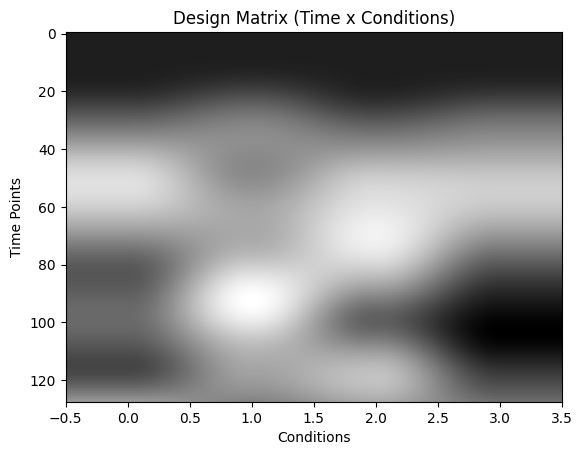

Design matrix shape: (128, 4)
Loaded 3 contrast(s)
Beta stats — min: -2876.845228768698 max: 2814.586335527002
Saved: output1/S08/8.pe1.nii.gz | min: -584.477, max: 2814.586, mean: 18.634
Saved: output1/S08/8.pe2.nii.gz | min: -1438.132, max: 241.302, mean: -8.693
Saved: output1/S08/8.pe3.nii.gz | min: -266.187, max: 1015.197, mean: 4.009
Saved: output1/S08/8.pe4.nii.gz | min: -2876.845, max: 446.599, mean: -15.443
Saved: output1/S08/8.cope1.nii.gz | min: -787.525, max: 4252.718, mean: 27.327
Saved: output1/S08/8.tstat1.nii.gz | min: -10.043, max: 8.806, mean: 0.597
Saved: output1/S08/8.zstat1.nii.gz | min: -8.574, max: 7.745, mean: 0.582
Saved: output1/S08/8.cope2.nii.gz | min: -551.547, max: 3809.419, mean: 19.452
Saved: output1/S08/8.tstat2.nii.gz | min: -11.007, max: 7.383, mean: 0.426
Saved: output1/S08/8.zstat2.nii.gz | min: -9.176, max: 6.708, mean: 0.420
Saved: output1/S08/8.cope3.nii.gz | min: -1315.529, max: 8062.137, mean: 46.779
Saved: output1/S08/8.tstat3.nii.gz | min: -14

In [9]:
if __name__ == "__main__":
    # if len(sys.argv) != 5:
    #     print("Usage: python glm.py <functional_file> <ev_list.txt> <contrast_file> <output_prefix>")
    #     sys.exit(1)

    func_file = "A4/S08.feat/filtered_func_data.nii.gz"
    ev_list_file = "EV_list.txt"
    contrast_file = "contrast.txt"
    out_prefix = "output1/S08/8"
    
    main(func_file, ev_list_file, contrast_file, out_prefix)

In [84]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def scatter_plot_comparison(fsl_file, my_file, title, output_file):
    fsl_img = nib.load(fsl_file).get_fdata().flatten()
    my_img = nib.load(my_file).get_fdata().flatten()

    # Optional: mask out zeros or NaNs
    mask = (fsl_img != 0) & (my_img != 0) & ~np.isnan(fsl_img) & ~np.isnan(my_img)

    plt.figure(figsize=(6, 6))
    plt.scatter(fsl_img[mask], my_img[mask], s=1, alpha=0.3)
    # plt.scatter(fsl_img, my_img, s=4, alpha=1)
    plt.xlabel("FSL Values")
    plt.ylabel("My Values")
    plt.title(title)
    plt.grid(True)
    plt.savefig(output_file)
    plt.show()


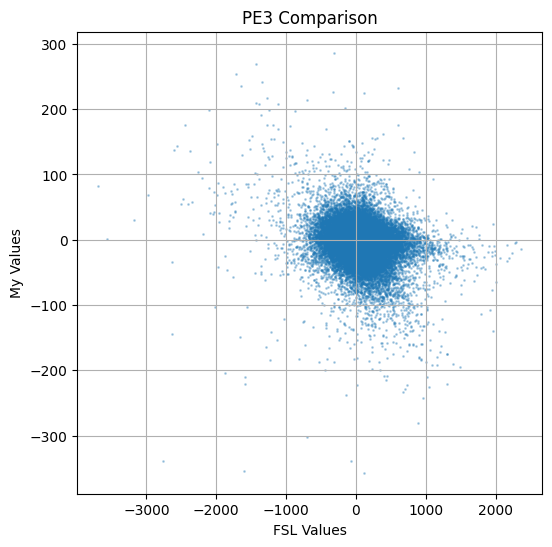

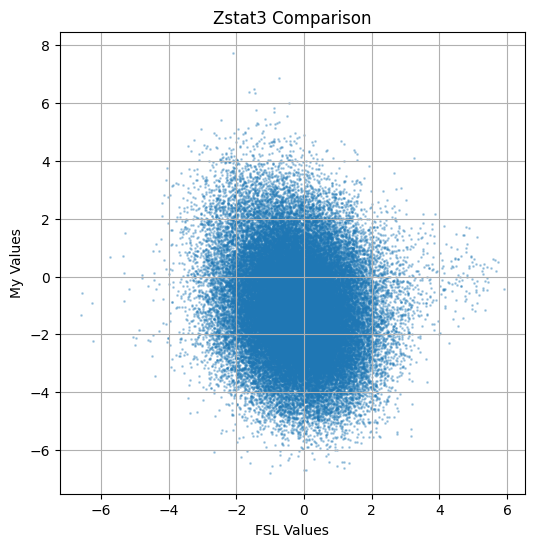

In [85]:
scatter_plot_comparison("A4/S01.feat/stats/pe3.nii.gz", "Output/output.pe3.nii.gz", 
                        "PE3 Comparison", "Output/pe3_comparison.png")

scatter_plot_comparison("A4/S01.feat/stats/zstat3.nii.gz", "Output/output.zstat3.nii.gz", 
                        "Zstat3 Comparison", "Output/zstat3_comparison.png")

In [78]:
def show_brain_maps(fsl_file, my_file, slice_index, title, output_file):
    fsl_img = nib.load(fsl_file).get_fdata()
    my_img = nib.load(my_file).get_fdata()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    vmin = -5
    vmax = 5
    axes[0].imshow(np.rot90(fsl_img[:, :, slice_index]), cmap='hot', vmin=vmin, vmax=vmax)
    axes[0].set_title("FSL")
    axes[0].axis("off")

    axes[1].imshow(np.rot90(my_img[:, :, slice_index]), cmap='hot', vmin=vmin, vmax=vmax)
    axes[1].set_title("Our Tool")
    axes[1].axis("off")

    fig.suptitle(title)
    plt.savefig(output_file)
    plt.show()


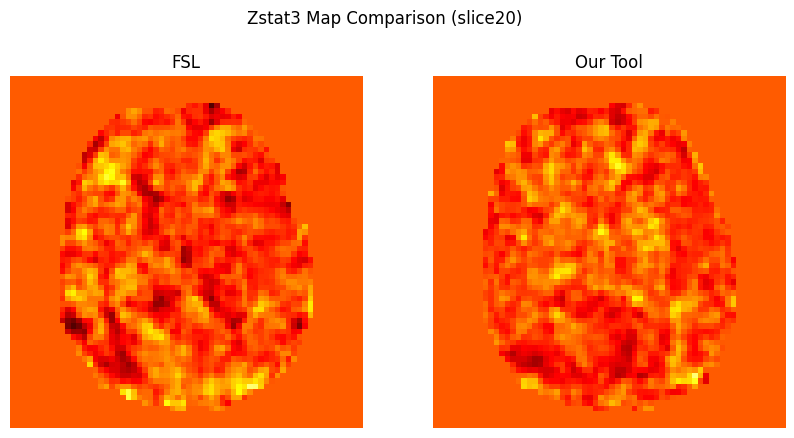

In [81]:
show_brain_maps("A4/S01.feat/stats/zstat3.nii.gz", "Output/output.zstat3.nii.gz", 
                slice_index=20, 
                title="Zstat3 Map Comparison (slice20)", 
                output_file="Output/zstat3_map_20.png")
